In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

# TensorFlow ≥2.4 is required in this notebook
# Earlier 2.x versions will mostly work the same, but with a few bugs
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.4"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "deep"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

#**12.2 넘파이처럼 텐서플로 사용하기**

In [2]:
#두 개의 행과 세 개의 열을 가진 실수 행렬
tf.constant([[1.,2.,3.],[4.,5.,6.]]) 

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[1., 2., 3.],
       [4., 5., 6.]], dtype=float32)>

In [3]:
#스칼라
tf.constant(42)

<tf.Tensor: shape=(), dtype=int32, numpy=42>

In [4]:
t = tf.constant([[1.,2.,3.],[4.,5.,6.]]) 
t.shape

TensorShape([2, 3])

In [5]:
t.dtype

tf.float32

In [6]:
t[:,1:]

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[2., 3.],
       [5., 6.]], dtype=float32)>

In [7]:
t[...,1,tf.newaxis]

<tf.Tensor: shape=(2, 1), dtype=float32, numpy=
array([[2.],
       [5.]], dtype=float32)>

In [8]:
#모든 종류의 텐서 연산이 가능하다
t+10
tf.square(t) #제곱
t @ tf.transpose(t)

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[14., 32.],
       [32., 77.]], dtype=float32)>

In [9]:
a = np.array([2.,4.,5.])
tf.constant(a)

<tf.Tensor: shape=(3,), dtype=float64, numpy=array([2., 4., 5.])>

In [10]:
t.numpy() #또는 np.array(t)

array([[1., 2., 3.],
       [4., 5., 6.]], dtype=float32)

In [11]:
tf.square(a)

<tf.Tensor: shape=(3,), dtype=float64, numpy=array([ 4., 16., 25.])>

In [12]:
np.square(t)

array([[ 1.,  4.,  9.],
       [16., 25., 36.]], dtype=float32)

In [13]:
t2 = tf.constant(40., dtype=tf.float64)
tf.constant(2.0) + tf.cast(t2, tf.float32)

<tf.Tensor: shape=(), dtype=float32, numpy=42.0>

In [14]:
tf.constant(2.) + tf.constant(40, dtype=tf.float32)

<tf.Tensor: shape=(), dtype=float32, numpy=42.0>

In [15]:
v = tf.Variable([[1.,2.,3.],[4.,5.,6.]])
v

<tf.Variable 'Variable:0' shape=(2, 3) dtype=float32, numpy=
array([[1., 2., 3.],
       [4., 5., 6.]], dtype=float32)>

In [16]:
v.assign(2*v)

<tf.Variable 'UnreadVariable' shape=(2, 3) dtype=float32, numpy=
array([[ 2.,  4.,  6.],
       [ 8., 10., 12.]], dtype=float32)>

In [17]:
v[0,1].assign(42)

<tf.Variable 'UnreadVariable' shape=(2, 3) dtype=float32, numpy=
array([[ 2., 42.,  6.],
       [ 8., 10., 12.]], dtype=float32)>

In [18]:
v[:,2].assign([0.,1.])

<tf.Variable 'UnreadVariable' shape=(2, 3) dtype=float32, numpy=
array([[ 2., 42.,  0.],
       [ 8., 10.,  1.]], dtype=float32)>

#**12.3 사용자 정의 모델과 훈련 알고리즘**

In [19]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()
X_train_full, X_test, y_train_full, y_test = train_test_split(
    housing.data, housing.target.reshape(-1, 1), random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

In [20]:
def huber_fn(y_true, y_pred):
  error = y_true - y_pred
  is_small_error = tf.abs(error) < 1
  squared_loss = tf.square(error) / 2
  linear_loss = tf.abs(error) - 0.5
  return tf.where(is_small_error, squared_loss, linear_loss)

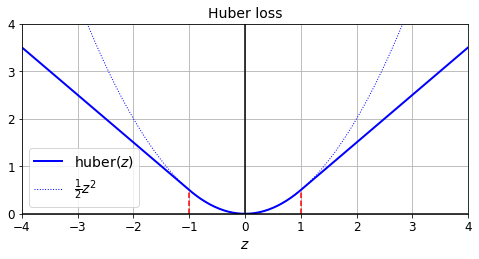

In [21]:
plt.figure(figsize=(8, 3.5))
z = np.linspace(-4, 4, 200)
plt.plot(z, huber_fn(0, z), "b-", linewidth=2, label="huber($z$)")
plt.plot(z, z**2 / 2, "b:", linewidth=1, label=r"$\frac{1}{2}z^2$")
plt.plot([-1, -1], [0, huber_fn(0., -1.)], "r--")
plt.plot([1, 1], [0, huber_fn(0., 1.)], "r--")
plt.gca().axhline(y=0, color='k')
plt.gca().axvline(x=0, color='k')
plt.axis([-4, 4, 0, 4])
plt.grid(True)
plt.xlabel("$z$")
plt.legend(fontsize=14)
plt.title("Huber loss", fontsize=14)
plt.show()

In [22]:
input_shape = X_train.shape[1:]

model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1),
])

In [23]:
model.compile(loss=huber_fn, optimizer='nadam')
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 2s 2ms/step - loss: 0.6235 - val_loss: 0.2862
Epoch 2/2
363/363 [==============================] - 1s 2ms/step - loss: 0.2197 - val_loss: 0.2382


In [24]:
model.save("my_model_with_a_custom_loss.h5")

In [25]:
moedl = keras.models.load_model("my_model_with_a_custom_loss.h5",
                                custom_objects={"huber_fn":huber_fn})

In [26]:
def create_huber(threshold=1.0):
    def huber_fn(y_true, y_pred):
        error = y_true - y_pred
        is_small_error = tf.abs(error) < threshold
        squared_loss = tf.square(error) / 2
        linear_loss  = threshold * tf.abs(error) - threshold**2 / 2
        return tf.where(is_small_error, squared_loss, linear_loss)
    return huber_fn

In [27]:
model.save("my_model_with_a_custom_loss_threshold_2.h5")

moedl = keras.models.load_model("my_model_with_a_custom_loss_threshold_2.h5",
                                custom_objects={"huber_fn":create_huber(2.0)})

In [28]:
 class HuberLoss(keras.losses.Loss):
    def __init__(self, threshold=1.0, **kwargs):
        self.threshold = threshold
        super().__init__(**kwargs)
    def call(self, y_true, y_pred):
        error = y_true - y_pred
        is_small_error = tf.abs(error) < self.threshold
        squared_loss = tf.square(error) / 2
        linear_loss  = self.threshold * tf.abs(error) - self.threshold**2 / 2
        return tf.where(is_small_error, squared_loss, linear_loss)
    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "threshold": self.threshold}

In [29]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1),
])

In [30]:
model.compile(loss=HuberLoss(2.), optimizer='nadam')

In [31]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 2s 2ms/step - loss: 0.7095 - val_loss: 0.3378
Epoch 2/2
363/363 [==============================] - 1s 2ms/step - loss: 0.2416 - val_loss: 0.2660


In [32]:
model.save("my_model_with_a_custom_loss_class.h5")

model = keras.models.load_model("my_model_with_a_custom_loss_class.h5",
                                custom_objects={"HuberLoss": HuberLoss})

In [33]:
def my_softplus(z): # return value is just tf.nn.softplus(z)
    return tf.math.log(tf.exp(z) + 1.0)

def my_glorot_initializer(shape, dtype=tf.float32):
    stddev = tf.sqrt(2. / (shape[0] + shape[1]))
    return tf.random.normal(shape, stddev=stddev, dtype=dtype)

def my_l1_regularizer(weights):
    return tf.reduce_sum(tf.abs(0.01 * weights))

def my_positive_weights(weights): # return value is just tf.nn.relu(weights)
    return tf.where(weights < 0., tf.zeros_like(weights), weights)

In [34]:
layer = keras.layers.Dense(1, activation=my_softplus,
                           kernel_initializer=my_glorot_initializer,
                           kernel_regularizer=my_l1_regularizer,
                           kernel_constraint=my_positive_weights)

In [35]:
class MyL1Regularizer(keras.regularizers.Regularizer):
    def __init__(self, factor):
        self.factor = factor
    def __call__(self, weights):
        return tf.reduce_sum(tf.abs(self.factor * weights))
    def get_config(self):
        return {"factor": self.factor}

In [36]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1, activation=my_softplus,
                       kernel_regularizer=MyL1Regularizer(0.01),
                       kernel_constraint=my_positive_weights,
                       kernel_initializer=my_glorot_initializer),
])

In [37]:
model.compile(loss="mse", optimizer="nadam", metrics=["mae"])

In [38]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 2s 2ms/step - loss: 1.3809 - mae: 0.8429 - val_loss: inf - val_mae: inf
Epoch 2/2
363/363 [==============================] - 1s 2ms/step - loss: 0.6669 - mae: 0.5528 - val_loss: 2.7498 - val_mae: 0.5489


In [39]:
model.compile(loss = 'mse', optimizer='nadam', metrics=[create_huber(2.0)])

In [40]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 2s 2ms/step - loss: 0.5589 - huber_fn: 0.2451 - val_loss: 1.8698 - val_huber_fn: 0.2788
Epoch 2/2
363/363 [==============================] - 1s 2ms/step - loss: 0.5161 - huber_fn: 0.2293 - val_loss: 1.3956 - val_huber_fn: 0.2601


In [41]:
precision = keras.metrics.Precision()
precision([0, 1, 1, 1, 0, 1, 0, 1], [1, 1, 0, 1, 0, 1, 0, 1]) #0.8

<tf.Tensor: shape=(), dtype=float32, numpy=0.8>

In [42]:
precision([0, 1, 0, 0, 1, 0, 1, 1], [1, 0, 1, 1, 0, 0, 0, 0]) #0.5

<tf.Tensor: shape=(), dtype=float32, numpy=0.5>

In [43]:
precision.result() #0.5

<tf.Tensor: shape=(), dtype=float32, numpy=0.5>

In [44]:
precision.variables
#[<tf.Variable 'true_positives:0' shape=(1,) dtype=float32, numpy=array([4.], dtype=float32)>,
#<tf.Variable 'false_positives:0' shape=(1,) dtype=float32, numpy=array([4.], dtype=float32)>]

[<tf.Variable 'true_positives:0' shape=(1,) dtype=float32, numpy=array([4.], dtype=float32)>,
 <tf.Variable 'false_positives:0' shape=(1,) dtype=float32, numpy=array([4.], dtype=float32)>]

In [45]:
precision.reset_states()

In [46]:
class HuberMetric(keras.metrics.Metric):
  def __init__(self, threshold=1.0, **kwargs):
    super().__init__(**kwargs) #기본 매개변수 처리(예, dtype)
    self.threshold = threshold
    self.huber_fn = create_huber(threshold)
    self.total = self.add_weight("total", initializer='zeros')
    self.count = self.add_weight("count", initializer='zeros')
  def update_state(self, y_true, y_pred, sample_weight=None):
    metric = self.huber_fn(y_true, y_pred)
    self.total.assign_add(tf.reduce_sum(metric))
    self.count.assign_add(tf.cast(tf.size(y_true), tf.float32))
  def result(self):
    return self.total / self.count
  def get_config(self):
    base_config = super().get_config()
    return {**base_config, "threshold": self.threshold}

In [47]:
m = HuberMetric(2.)
m(tf.constant([[2.]]), tf.constant([[10.]])) 

<tf.Tensor: shape=(), dtype=float32, numpy=14.0>

In [48]:
m(tf.constant([[0.], [5.]]), tf.constant([[1.], [9.25]]))
m.result()

<tf.Tensor: shape=(), dtype=float32, numpy=7.0>

In [49]:
exponential_layer = keras.layers.Lambda(lambda x: tf.exp(x))

In [50]:
class MyMultiLayer(keras.layers.Layer):
    def call(self, X):
        X1, X2 = X
        print("X1.shape: ", X1.shape ," X2.shape: ", X2.shape) # Debugging of custom layer
        return X1 + X2, X1 * X2

    def compute_output_shape(self, batch_input_shape):
        batch_input_shape1, batch_input_shape2 = batch_input_shape
        return [batch_input_shape1, batch_input_shape2]

In [51]:
class MyGaussianNoise(keras.layers.Layer):
  def __init__(self, stddev, **kwargs):
    super().__init__(**kwargs)
    self.stddev = stddev

  def call(self, X, training = None):
    if training:
      noise = tf.random.normal(tf.shape(X), stddev=self.stddev)
      return X + noise
    else:
      return X

  def compute_output_shape(self, batch_input_shape):
    return batch_input_shape

In [52]:
class ResidualBlock(keras.layers.Layer):
    def __init__(self, n_layers, n_neurons, **kwargs):
        super().__init__(**kwargs)
        self.hidden = [keras.layers.Dense(n_neurons, activation="elu",
                                          kernel_initializer="he_normal")
                       for _ in range(n_layers)]

    def call(self, inputs):
        Z = inputs
        for layer in self.hidden:
            Z = layer(Z)
        return inputs + Z

In [53]:
class ResidualRegressor(keras.models.Model):
    def __init__(self, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.hidden1 = keras.layers.Dense(30, activation="elu",
                                          kernel_initializer="he_normal")
        self.block1 = ResidualBlock(2, 30)
        self.block2 = ResidualBlock(2, 30)
        self.out = keras.layers.Dense(output_dim)

    def call(self, inputs):
        Z = self.hidden1(inputs)
        for _ in range(1 + 3):
            Z = self.block1(Z)
        Z = self.block2(Z)
        return self.out(Z)

In [54]:
class ReconstructingRegressor(keras.Model):
    def __init__(self, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.hidden = [keras.layers.Dense(30, activation="selu",
                                          kernel_initializer="lecun_normal")
                       for _ in range(5)]
        self.out = keras.layers.Dense(output_dim)
        self.reconstruction_mean = keras.metrics.Mean(name="reconstruction_error")

    def build(self, batch_input_shape):
        n_inputs = batch_input_shape[-1]
        self.reconstruct = keras.layers.Dense(n_inputs)
        #super().build(batch_input_shape)

    def call(self, inputs, training=None):
        Z = inputs
        for layer in self.hidden:
            Z = layer(Z)
        reconstruction = self.reconstruct(Z)
        recon_loss = tf.reduce_mean(tf.square(reconstruction - inputs))
        self.add_loss(0.05 * recon_loss)
        if training:
            result = self.reconstruction_mean(recon_loss)
            self.add_metric(result)
        return self.out(Z)

In [55]:
def f(w1,w2):
  return 3*w1**2 + 2*w1*w2

In [56]:
w1, w2 = 5,3
eps = 1e-6
(f(w1+eps,w2)-f(w1,w2))/eps
(f(w1,w2+eps)-f(w1,w2))/eps

10.000000003174137

In [57]:
w1, w2 = tf.Variable(5.) , tf.Variable(3.)
with tf.GradientTape() as tape:
  z = f(w1,w2)

gradients = tape.gradient(z,[w1,w2])

In [58]:
gradients

[<tf.Tensor: shape=(), dtype=float32, numpy=36.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=10.0>]

In [59]:
with tf.GradientTape() as tape:
  z = f(w1,w2)

dz_dw1 = tape.gradient(z,w1)
#dz_dw2 = tape.gradient(z,w2) #실행 에러

In [60]:
with tf.GradientTape(persistent=True) as tape:
  z = f(w1,w2)

dz_dw1 = tape.gradient(z,w1)
dz_dw2 = tape.gradient(z,w2)
del tape

In [61]:
c1, c2 = tf.constant(5.), tf.constant(3.)
with tf.GradientTape() as tape:
    z = f(c1, c2)

gradients = tape.gradient(z, [c1, c2])
gradients

[None, None]

In [62]:
with tf.GradientTape() as tape:
    tape.watch(c1)
    tape.watch(c2)
    z = f(c1, c2)

gradients = tape.gradient(z, [c1, c2])
gradients

[<tf.Tensor: shape=(), dtype=float32, numpy=36.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=10.0>]

In [63]:
def f(w1, w2):
    return 3 * w1 ** 2 + tf.stop_gradient(2 * w1 * w2)

with tf.GradientTape() as tape:
    z = f(w1, w2)

tape.gradient(z, [w1, w2]) #[30, None]

[<tf.Tensor: shape=(), dtype=float32, numpy=30.0>, None]

In [64]:
x = tf.Variable(100.)
with tf.GradientTape() as tape:
    z = my_softplus(x)

tape.gradient(z, [x]) #NaN

[<tf.Tensor: shape=(), dtype=float32, numpy=nan>]

In [65]:
@tf.custom_gradient
def my_better_softplus(z):
    exp = tf.exp(z)
    def my_softplus_gradients(grad):
        return grad / (1 + 1 / exp)
    return tf.math.log(exp + 1), my_softplus_gradients

def my_better_softplus(z):
    return tf.where(z > 30., z, tf.math.log(tf.exp(z) + 1.))

In [66]:
x = tf.Variable([1000.])
with tf.GradientTape() as tape:
    z = my_better_softplus(x)

z, tape.gradient(z, [x])

(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([1000.], dtype=float32)>,
 [<tf.Tensor: shape=(1,), dtype=float32, numpy=array([nan], dtype=float32)>])

In [66]:
l2_reg = keras.regularizers.l2(0.05)
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="elu", kernel_initializer="he_normal",
                       kernel_regularizer=l2_reg),
    keras.layers.Dense(1, kernel_regularizer=l2_reg)
])

In [67]:
def random_batch(X,y, batch_size=32):
  idx = np.random.randint(len(X), size=batch_size)
  return X[idx], y[idx]

In [68]:
def print_status_bar(iteration, total, loss, metrics=None):
    metrics = " - ".join(["{}: {:.4f}".format(m.name, m.result())
                         for m in [loss] + (metrics or [])])
    end = "" if iteration < total else "\n"
    print("\r{}/{} - ".format(iteration, total) + metrics,
          end=end)

In [69]:
n_epochs = 5
batch_size = 32
n_steps = len(X_train) // batch_size
optimizer = keras.optimizers.Nadam(learning_rate=0.01)
loss_fn = keras.losses.mean_squared_error
mean_loss = keras.metrics.Mean()
metrics = [keras.metrics.MeanAbsoluteError()]

In [71]:
for epoch in range(1, n_epochs + 1):
    print("Epoch {}/{}".format(epoch, n_epochs))
    for step in range(1, n_steps + 1):
        X_batch, y_batch = random_batch(X_train_scaled, y_train)
        with tf.GradientTape() as tape:
            y_pred = model(X_batch)
            main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
            loss = tf.add_n([main_loss] + model.losses)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        mean_loss(loss)
        for metric in metrics:
            metric(y_batch, y_pred)
        print_status_bar(step * batch_size, len(y_train), mean_loss, metrics)
    print_status_bar(len(y_train), len(y_train), mean_loss, metrics)
    for metric in [mean_loss] + metrics:
        metric.reset_states()

Epoch 1/5
11610/11610 - mean: 0.5080 - mean_absolute_error: 0.4792
Epoch 2/5
11610/11610 - mean: 0.4412 - mean_absolute_error: 0.4642
Epoch 3/5
11610/11610 - mean: 0.4398 - mean_absolute_error: 0.4600
Epoch 4/5
11610/11610 - mean: 0.4139 - mean_absolute_error: 0.4502
Epoch 5/5
11610/11610 - mean: 0.4246 - mean_absolute_error: 0.4545


In [70]:
for epoch in range(1, n_epochs + 1):
    print("Epoch {}/{}".format(epoch, n_epochs))
    for step in range(1, n_steps + 1):
        X_batch, y_batch = random_batch(X_train_scaled, y_train)
        with tf.GradientTape() as tape:
            y_pred = model(X_batch)
            main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
            loss = tf.add_n([main_loss] + model.losses)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        for variable in model.variables:
            if variable.constraint is not None:
                variable.assign(variable.constraint(variable))
        mean_loss(loss)
        for metric in metrics:
            metric(y_batch, y_pred)
        print_status_bar(step * batch_size, len(y_train), mean_loss, metrics)
    print_status_bar(len(y_train), len(y_train), mean_loss, metrics)
    for metric in [mean_loss] + metrics:
        metric.reset_states()

Epoch 1/5
11610/11610 - mean: 0.5268 - mean_absolute_error: 0.4934
Epoch 2/5
11610/11610 - mean: 0.4883 - mean_absolute_error: 0.4862
Epoch 3/5
11610/11610 - mean: 0.4560 - mean_absolute_error: 0.4731
Epoch 4/5
11610/11610 - mean: 0.4697 - mean_absolute_error: 0.4753
Epoch 5/5
11610/11610 - mean: 0.4565 - mean_absolute_error: 0.4736


#**12.4 텐서플로 함수와 그래프**

In [72]:
def cube(x):
  return x**3

In [74]:
cube(2) #8
cube(tf.constant(2.0)) #<tf.Tensor: shape=(), dtype=float32, numpy=8.0>

<tf.Tensor: shape=(), dtype=float32, numpy=8.0>

In [75]:
tf_cube = tf.function(cube)
tf_cube 

In [81]:
tf_cube(2) #<tf.Tensor: shape=(), dtype=int32, numpy=8>
tf_cube(tf.constant(2.0)) #<tf.Tensor: shape=(), dtype=float32, numpy=8.0>

<tf.Tensor: shape=(), dtype=float32, numpy=8.0>

In [82]:
@tf.function
def tf_cube(x):
  return x**3

In [83]:
tf_cube.python_function(2) #8

8